## Parse results from algos

In [1]:
import numpy as np
import numba as nb
import pandas as pd

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../../../src')
import networkx as nx

In [2]:
import io_m.libsaving as libsaving
import io_m.io_utils as io_utils

from importlib import reload

In [3]:
from epigen import epidemy_gen

In [4]:
from epigen.base import EpInstance

In [5]:
type_graph="proximity"
N=100
d=10
height=3
lam=0.03
mu=0.02
t_limit=15
scale=2
#gamma=1e-3
#path_contacts="../patient_zero/work/work_13_contacts.npz"
#small_lambda_limit=0

gamma=None
small_lambda_limit=0
path_contacts=" "

p_edge=1
nsrc=1


In [6]:
seeds=range(0,100)

In [7]:
INSTANCES = {s:EpInstance(type_graph, N, d, t_limit, 
                                    lam, mu, s, float(p_edge), 
                                    n_source=nsrc) for s in seeds}

In [8]:
str(INSTANCES[0])

'proximity_n_100_d_10_tlim_15_lam_0.03_mu_0.02_s_0_pe_1.0'

In [9]:
extra_gen = {"h":height,
            "scale":scale}

extra_gen.update({"gamma":gamma, 
                  "small_lambda_limit":small_lambda_limit, 
                  "path_contacts": path_contacts})

In [10]:

start_conf=0
num_conf=1

In [11]:
%%capture
reload(epidemy_gen)
DATA_ALL = {s: 
            epidemy_gen.epidemy_gen_epinstance(inst, 
                                               lim_infected=1, num_conf=num_conf,
                                               extra_gen=extra_gen, 
                                               verbose=False,
                                              num_sources=nsrc) 
            for s, inst in INSTANCES.items()}

In [12]:
confs={s: np.array(mdata["test"]) for s, mdata in DATA_ALL.items()}

final_confs = {
    s: c[...,1,:] for s, c in confs.items()
} #np.stack(tuple(confs.values()) )[...,1,:]


idx_source = {k: np.stack((np.where(c[0]==1)[0] for c in x)) for k, x in confs.items()}

/home/fmazza/app/miniconda3/envs/torche/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
idx_source[1]

array([[17]])

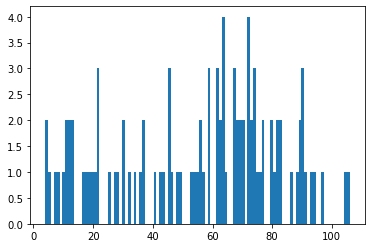

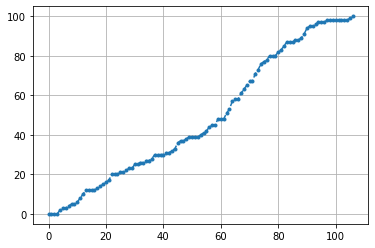

In [14]:
r = np.stack(tuple(final_confs.values())).sum(-1).flatten()
plt.figure()
plt.hist(r,bins=max(r)+1)

plt.figure()
x,vals = np.unique(r, return_counts=True)
allvals = np.zeros(max(x)+1)
allvals[x] = vals
plt.plot(allvals.cumsum(),".--")
plt.grid()

In [15]:
from epigen import generators

In [16]:
EPIDEMIES = {s: generators.calc_epidemies(mdata["epidemy"], mdata["test"], t_limit) 
             for s, mdata in DATA_ALL.items()}

## Read marginals

In [17]:
from io_m import read_results

In [18]:
def load_many_inst(method, folder, instances, *args, **kwargs):
    #if "legacy" in kwargs.keys():
    #    for inst in 
    return {s: method(folder, inst, *args,**kwargs) for s, inst in instances.items()}

In [19]:
margs_all = {}

In [20]:
reload(read_results)

<module 'io_m.read_results' from '../../../src/io_m/read_results.py'>

In [21]:
for inst in INSTANCES.values():
    inst.p_edge=int(inst.p_edge)

In [22]:
confs_load=(0,num_conf)

In [23]:
folder=f"data/"
#folder=f"sib/{INSTANCE.type_graph}_nsrc{nsrc}/"
name_file=""
margs_all["sib"] =load_many_inst(read_results.read_sib_data_def,
                                        #"sib/{type_graph}_nsrc1/",
                                        folder+"sib",
                                        #f"sib/{type_graph}/",
                                        INSTANCES, height, name_file,
                                        range_confs=confs_load, outprint=False)

## ANN results

In [24]:
reload(read_results)

<module 'io_m.read_results' from '../../../src/io_m/read_results.py'>

In [25]:
str(INSTANCES[0])

'proximity_n_100_d_10_tlim_15_lam_0.03_mu_0.02_s_0_pe_1'

In [26]:
margs_all["ann_old"] = load_many_inst(read_results.read_margs_inst,
                                        #"sib/{type_graph}_nsrc1/",
                                        folder+"ann",
                                        #f"sib/{type_graph}/",
                                        INSTANCES, prefix=name_file, algo="ann",
                                        range_confs=confs_load, outprint=False)

In [ ]:
margs_all["ann_new"] = load_many_inst(read_results.read_margs_inst,
                                        #"sib/{type_graph}_nsrc1/",
                                        "data_new/ann",
                                        #f"sib/{type_graph}/",
                                        INSTANCES, prefix=name_file,
                                        range_confs=confs_load, outprint=False)

In [ ]:
margs_all["ann_new_check"] = load_many_inst(read_results.read_margs_inst,
                                        #"sib/{type_graph}_nsrc1/",
                                        "data_new/ann_check/",
                                        #f"sib/{type_graph}/",
                                        INSTANCES, prefix="ann_test_",
                                        range_confs=confs_load, outprint=False)

In [ ]:
margs_all["ann_old_redo"] = load_many_inst(read_results.read_margs_inst,
                                        #"sib/{type_graph}_nsrc1/",
                                        "data/ann_old_lays/",
                                        #f"sib/{type_graph}/",
                                        INSTANCES, prefix="",
                                        range_confs=confs_load, outprint=False)

## Soft Margin

In [28]:
from pathlib import Path

In [29]:
from soft_margin.saving import load_data_softmargin

In [30]:
def load_softm_res(instance, path_fold, nsim_r, verbose=False):
    smfold=Path(path_fold)
    base_file_name = (smfold / (str(instance)+f"_nc_1_softm_nsims_{nsim_r}_rep_0")).as_posix()
    if verbose: print(base_file_name)
    res = load_data_softmargin(base_file_name)
    return res

In [31]:
from collections import defaultdict

In [32]:
softm_data = defaultdict(dict)
probs_softm = defaultdict(dict)

In [33]:
nsims_softm=[int(1e6), int(1e7), int(1e8)]

In [34]:
for s, inst in INSTANCES.items():
    for nsim in nsims_softm:
        #print(s, nsim)
        softm_data[s][nsim]=load_softm_res(inst, "data/sm", nsim, verbose=False)
        x = softm_data[s][nsim][1]
        probs_softm[s][nsim] = [x[v] for v in sorted(x.keys())]

## Patient zero

In [53]:
def get_random_margs():
    x = np.random.rand(N,t_limit+1,3)
    return x / x.sum(-1)[...,np.newaxis]

margs_all["random"] = {s: [get_random_margs() for _ in range(start_conf, start_conf+num_conf)]
                      for s in DATA_ALL.keys()}

In [36]:
N_inf = {s:[np.sum(np.array(c[1])!=0) for c in mdata["test"] ]
         for s, mdata in DATA_ALL.items()}

In [37]:
sources = {s:
    np.stack( [np.where(np.array(c[0])==1)[0] for c in mdata["test"] ])
           for s, mdata in DATA_ALL.items()}

In [38]:
SOURCE_CANDIDS = {s:
     [np.where(np.array(c[1])!=0)[0] for c in mdata["test"] ]
           for s, mdata in DATA_ALL.items()}

In [39]:
from sklearn.metrics import auc, roc_curve

In [40]:
def get_source_rank(m, msources):
    psources = m[:,0,1]
    idx=psources.argsort()[::-1]

    rg = sum(((idx == s for s in msources)))
    #print(rg)
    return rg.cumsum()

def get_sources_auc(m, msources, m_psrc=False):
    
    if m_psrc: 
        psources = m
    else:
        psources = m[:,0,1]

    idx=psources.argsort()[::-1]
    truey = np.zeros(psources.shape, dtype=int)
    #rg = sum(((idx == s for s in msources)))
    truey[msources] = 1
    #print(rg)
    fpr,tpr,thr= roc_curve(truey, psources)#rg.cumsum()
    return auc(fpr,tpr)

In [41]:
def get_sources_auc_cands(m, msources, cands, m_psrc=False):
    
    if m_psrc: 
        psrc = m
    else:
        psrc = m[:,0,1]
    
    psources = psrc[cands]

    truey = sum(cands == s for s in msources)
    #print(rg)
    fpr,tpr,thr= roc_curve(truey, psources)#rg.cumsum()
    return auc(fpr,tpr)

In [42]:
def get_source_posit(m, msources):
    psources = m[:,0,1]
    idx=psources.argsort()[::-1]
    pos = [np.argmax(idx == s) for s in msources]
    return pos

In [44]:
def get_source_rank_probs(psources, msources):
    idx=psources.argsort()[::-1]
    #print(idx.shape)

    rg = sum((idx == s for s in msources))
    #print(rg)
    #print(rg.shape)
    #print(np.where(idx==msources[0]))
    return rg.cumsum(-1)

In [45]:
ranks_softm = {}
for nsim in nsims_softm:
    
    source_found = np.stack([
                    [
                        [
                            get_source_rank_probs(x, inst_src) #for x  in
                            for x in probs_softm[seed][nsim][i]
                        ]
                        for i, inst_src in enumerate(srcs)
                    ]
                    for seed, srcs in sources.items()
                ])
    #print(source_found.shape)
    #print(source_found)
    
    ranks_softm[nsim] = source_found.sum(0).sum(0)
    #print(ranks_softm)
    #break


In [54]:
pzero_accu = {name: 
            np.stack([
                np.array([get_source_rank(m,source) 
                          for m, source in zip(marg[s], sources[s])])
                for s in sources.keys()
            ]).sum(0).sum(0)
            for name, marg in margs_all.items()}

In [47]:
from analysis.sources import get_src_posit_obs_margs

In [59]:
from utils.common import pretty_print_n

In [55]:
pzero_pos_scaled = {name: 
            np.stack([
                np.array([get_src_posit_obs_margs(m,source, candids) 
                 for m, source, candids in zip(marg[s], sources[s], SOURCE_CANDIDS[s])])
                for s in sorted(sources.keys())
            ])
            for name, marg in margs_all.items()}

In [56]:
pzero_pos_softm = {nsi: 
            np.stack([
                np.array([
                    [get_src_posit_obs_margs(np.stack((np.zeros_like(m),m),axis=1)[:,np.newaxis]
                                                  ,source, candids)
                          for m in probs]
                 for probs, source, candids in zip(probs_softm[s][nsi], sources[s], SOURCE_CANDIDS[s])])
                for s in sorted(sources.keys())
            ])
            for nsi in nsims_softm}

In [57]:
import analysis.generic as analy
reload(analy)

<module 'analysis.generic' from '../../../src/analysis/generic.py'>

1000000
10000000
100000000


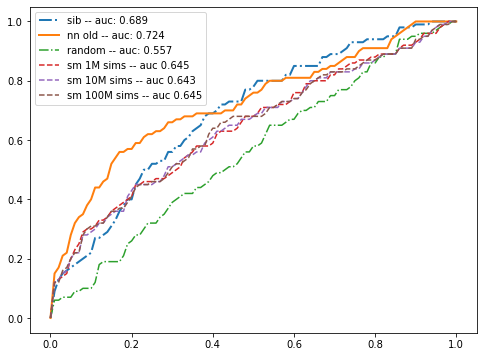

In [60]:
plt.figure(figsize=(8,6))
d=analy.make_histo_cumsum(pzero_pos_scaled["sib"],)
plt.plot(*d, "-.", label=f"sib -- auc: {auc(*d):.3f}", linewidth="2")

#d=get_curve_all(pzero_pos_scaled["ann_old_redo"], scale=100,)
#plt.plot(*d, label=f"nn old redo -- auc: {auc(*d):.3f}", linewidth="2")
d=analy.make_histo_cumsum(pzero_pos_scaled["ann_old"],)
plt.plot(*d, label=f"nn old -- auc: {auc(*d):.3f}", linewidth="2")
#d=get_curve_all(pzero_pos_scaled["ann_new"], scale=100,)

d=analy.make_histo_cumsum(pzero_pos_scaled["random"],)
plt.plot(*d, "-.", label=f"random -- auc: {auc(*d):.3f}")
#plt.plot(*d, label=f"nn new -- auc: {auc(*d):.3f}", linewidth="2")
#d=get_curve_all(pzero_pos_scaled["ann_new_check"], scale=100,)
#plt.plot(*d, "--",label=f"nn new check -- auc: {auc(*d):.3f}", linewidth="2")
softm_pars_idx = 25
softm_alpha = softm_data[0][int(1e6)][0][softm_pars_idx]
for k in pzero_pos_softm:
    print(k)
    d=analy.make_histo_cumsum(pzero_pos_softm[k][..., softm_pars_idx],)
    plt.plot(*d,"--", label="sm {} sims -- auc {:.3f}".format(pretty_print_n(k), auc(*d))) 
plt.legend()

In [62]:
pzero_auc = {name: 
            np.stack([
                np.array([get_sources_auc(m,source) for m, source in zip(marg[s], sources[s])])
                for s in sources.keys()
            ]).mean(-1)
            for name, marg in margs_all.items()}

In [63]:
pzero_auc_onlyI = {name: 
            np.stack([
                np.array([get_sources_auc_cands(m,source, cds) for m, source, cds in zip(marg[s], sources[s], SOURCE_CANDIDS[s])])
                for s in sources.keys()
            ]).mean(-1)
            for name, marg in margs_all.items()}

In [64]:
softm_pzero_auc = {nsim: 
            np.stack([
                np.array([ [get_sources_auc(p,source,m_psrc=True) for p in m] for m, source in zip(probs_softm[s][nsim], sources[s])])
                for s in sources.keys()
            ])
            for nsim in nsims_softm}

In [65]:
softm_pzero_auc_onlyI = {nsim: 
            np.stack([
                np.array([ [get_sources_auc_cands(p,source,cds,m_psrc=True) for p in m] 
                          for m, source, cds in zip(probs_softm[s][nsim], sources[s],  SOURCE_CANDIDS[s])])
                for s in sources.keys()
            ])
            for nsim in nsims_softm}

In [68]:
for k in sorted(pzero_auc.keys()):
    aal = pzero_auc[k]
    print("{}, {:4.3f} \pm {:4.3f} ".format(
        k, np.nanmean(aal), np.nanstd(aal)/np.sqrt(np.prod(aal.shape)-np.isnan(aal).sum()))
    )
    #plt.plot(aal, label=k)
    
#plt.legend()

ann_old, 0.828 \pm 0.021 
random, 0.547 \pm 0.029 
sib, 0.828 \pm 0.019 


In [69]:
for k in sorted(pzero_auc.keys()):
    aal = pzero_auc_onlyI[k]
    print("{}, {:4.3f} \pm {:4.3f} ".format(
        k, np.nanmean(aal), np.nanstd(aal)/np.sqrt(np.prod(aal.shape)-np.isnan(aal).sum()))
    )
    #plt.plot(aal, label=k)
    

ann_old, 0.717 \pm 0.029 
random, 0.544 \pm 0.029 
sib, 0.680 \pm 0.026 


1000000
10000000
100000000


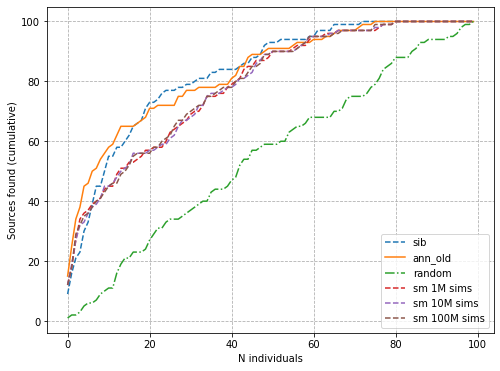

In [70]:
plt.figure(figsize=(8,6))
#for name,x in avg_count_probs.items():
#    plt.plot(x, label=name)
#    print()
#for name,x in avg_count_risk.items():
#    plt.plot(x, label=name)
#plt.plot(ul.mean(0))
x_data = np.arange(N)
#plt.plot(x_data,pzero_accu["sib_psus60"], "--",label="BP")
plt.plot(x_data,pzero_accu["sib"], "--",label="sib")
#, auc: {:4.3f}".format(auc_risk2["sib_psus60"]))
l = "ann_"
#plt.plot(x_data,pzero_accu["ann_psus06_4lpow"], label="ANN")#, auc: {:4.3f}".format(auc_risk2["ann_psus06Fin"]))

plt.plot(x_data,pzero_accu["ann_old"], label="ann_old")
#plt.plot(x_data,pzero_accu["ann_new"], label="ann_new")
#plt.plot(x_data,pzero_accu["ann_new_check"], label="ann_new all nodes")

#plt.plot(x_data,pzero_accu["ann_old_redo"], label="ann_old redo")

plt.plot(x_data,pzero_accu["random"],"-.", label="random")
softm_pars_idx = 25
softm_alpha = softm_data[0][int(1e6)][0][softm_pars_idx]
for k in ranks_softm:
    print(k)
    plt.plot(x_data,ranks_softm[k][softm_pars_idx],"--", label="sm {} sims".format(pretty_print_n(k)))


plt.legend()
plt.ylabel("Sources found (cumulative)")
plt.xlabel("N individuals")
plt.grid(linestyle="--")

In [75]:
softm_alphas=softm_data[0][int(1e6)][0]

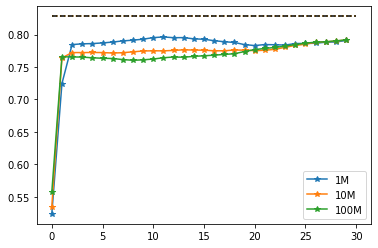

In [76]:
for k in softm_pzero_auc:
    plt.plot(softm_pzero_auc[k].mean(0).flatten(), "*-", label=pretty_print_n(k))
plt.hlines(pzero_auc["sib"].mean(), 0, 30, colors="orange", linestyles="dotted")

plt.hlines(pzero_auc["ann_old"].mean(), 0, 30, colors="black", linestyles="dashed")
plt.legend()

Text(0, 0.5, 'AUCs in finding the source (between I/R)')

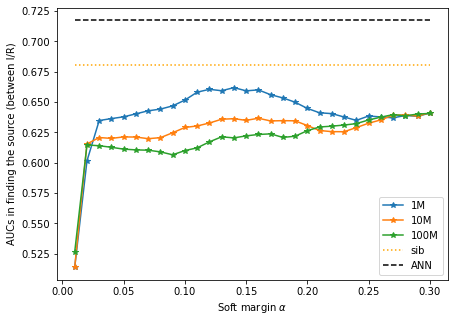

In [79]:
plt.figure(figsize=(7,5))
x=softm_alphas
for k in softm_pzero_auc_onlyI:
    plt.plot(x,softm_pzero_auc_onlyI[k].mean(0).flatten(), "*-", label=pretty_print_n(k))

xlims=plt.gca().get_xlim()
plt.hlines(pzero_auc_onlyI["sib"].mean(), min(x), max(x), colors="orange", linestyles="dotted", label="sib")

plt.hlines(pzero_auc_onlyI["ann_old"].mean(), min(x), max(x), colors="black", linestyles="dashed", label="ANN")
plt.legend(loc="lower right")
plt.xlim(xlims)
plt.xlabel("Soft margin $\\alpha$")
plt.ylabel("AUCs in finding the source (between I/R)")